In [142]:
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.PDB import *
from Bio.SeqUtils.ProtParam import ProteinAnalysis, ProtParamData
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import nglview as nv
import ipywidgets
from os import listdir
import requests
import json
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import matthews_corrcoef

import warnings
warnings.filterwarnings('ignore')

In [184]:
# Index of Hydrophobicity
hydrophobicity = {"A": 0.62, "C": 0.29, "D": -0.9, "E": -0.74, "F": 1.19, "G": 0.48, "H": -0.4, "I": 1.38, "K": -1.5, "L": 1.06, "M": 0.64, 
"N": -0.78, "P": 0.12, "Q": -0.85, "R": -2.53, "S": -0.18,  "T": -0.05, "V": 1.08,  "W": 0.81, "Y": 0.26}

# index of hydrophilicity
hydrophilicity = {"A": -0.5, "C": -1, "D": 3, "E": 3, "F": -2.5, "G": 0, "H": -0.5, "I": -1.8, "K": 3, "L": -1.8, "M": -1.3, 
"N": 0.2, "P": 0, "Q": 0.2, "R": 3, "S": 0.3,  "T": -0.4, "V": -1.5,  "W": -3.4, "Y": -2.3}

# Charged Amino acids
charged = {"A": 0, "R": 1, "N": 0, "D": 1, "C": 0, "U": 0, 
      "Q": 0, "E": 1, "G": 0, "H": 1, "I": 0, 
      "L": 0, "K": 1, "M": 0, "F": 0, "P": 0, 
      "S": 0, "T": 0, "W": 0, "Y": 0, "V": 0, "X": 0}

# amino_acids to numbers
res_to_num = {"A": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6, "H": 7, "I": 8, "K": 9, "L": 10, "M": 11, 
"N": 12, "P": 13, "Q": 14, "R": 15, "S": 16,  "T": 17, "V": 18,  "W": 19, "Y": 20}

amino_acids = ['CYS', 'ASP', 'SER', 'GLN', 'LYS', 'ILE', 'PRO', 'THR', 'PHE', 'ASN', 'GLY', 'HIS', 'LEU', 'ARG', 'TRP', 'ALA', 'VAL', 'GLU', 'TYR', 'MET']

d3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

### PDB files

In [16]:
pdb_structures = {}
# read all pdb files
for f in listdir("./data"):
  pdb_parser = PDBParser(PERMISSIVE=1)
  structure = pdb_parser.get_structure(f[:4], "./data/" + f)
  pdb_structures[f[:4]] = {}
  pdb_structures[f[:4]]['structure'] = structure

In [ ]:
# Opening JSON file
f = open('primary_structures.json')

# returns JSON object as a dictionary
data = json.load(f)

# get subunits for pdb files
for i in data['objects']:
  if i['pdbid'] in pdb_structures:
    x = requests.get('https://lomize-group-opm.herokuapp.com//primary_structures/' + str(i['id'])).json()
    pdb_structures[i['pdbid']]['subunits'] = x['subunits']

In [7]:
for model in pdb_structures['3gd8']:
  for chain in model:
    seq = []
    for residue in chain:
      if residue.resname in amino_acids:
        seq.append(d3to1[residue.resname])

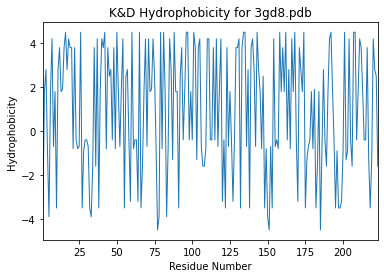

In [10]:
# names, counts = zip(*kd.items())
# print(values[0])
x_data = range(1, len(seq)+1)
plt.plot(x_data, values_hyd, linewidth=1.0)
plt.axis(xmin = 1, xmax = len(seq))
# plt.figure(figsize=(20, 15))
plt.xlabel("Residue Number")
plt.ylabel("Hydrophobicity")
plt.title("K&D Hydrophobicity for 3gd8.pdb")
plt.show()

In [ ]:
for key in pdb_structures:
  for model in pdb_structures[key]['structure']:
      
    pdb_structures[key]['seq'] = {}
    pdb_structures[key]['seq']['sequence'] = {}
    pdb_structures[key]['seq']['chain'] = {}
    
    chain_lenght = 0
    selected_chain = ''
    chain_index = 0
    
    for index, chain in enumerate(model):
      # get the chain with the maximun number of residue
      if chain_lenght < len(chain):
        chain_lenght = len(chain)
        selected_chain = chain
        chain_index = index

    pdb_structures[key]['seq']['chain'][selected_chain.id] = []
    
    # get segments
    if len(pdb_structures[key]['subunits']) == 0: # if we don't have information about segments, then protein is outside
      segments = '(0-0)'
    elif len(pdb_structures[key]['subunits'])-1 < index: # if we don't have the specific subunit, then take the first one
      segments = pdb_structures[key]['subunits'][0]['segment']
    elif pdb_structures[key]['subunits'][index]['protein_letter'] == selected_chain.id: # else, take this based on the protein letter
      segments = pdb_structures[key]['subunits'][index]['segment']
    # find all segments
    contents_re = re.findall('\(.*?\)',segments)
    # remove parenthesis 
    contents_re = [i.replace('(', '').replace(')', '') for i in contents_re]
      
    seq = []
    full_sequence = ''
    for res_index, residue in enumerate(selected_chain):
      if residue.resname in amino_acids:
        full_sequence += d3to1[residue.resname]
        # check if residue belongs to transmembrane segments
        is_tm_segment = False
        for sg in contents_re:
          if residue.id[1] in range(int(sg.split('-')[0]), int(sg.split('-')[1]) + 1):
            is_tm_segment = True

        if is_tm_segment:
          seq.append([d3to1[residue.resname], res_to_num[d3to1[residue.resname]], res_index, residue.id[1], hydrophobicity[d3to1[residue.resname]], hydrophilicity[d3to1[residue.resname]], charged[d3to1[residue.resname]], 1])
        else:
          seq.append([d3to1[residue.resname], res_to_num[d3to1[residue.resname]], res_index, residue.id[1], hydrophobicity[d3to1[residue.resname]], hydrophilicity[d3to1[residue.resname]], charged[d3to1[residue.resname]], 0])
    
    pdb_structures[key]['seq']['sequence'] = full_sequence
    pdb_structures[key]['seq']['chain'][selected_chain.id].append(seq)

In [ ]:
# write pdb data to json
temp_dict = {}
for key in pdb_structures:
  temp_dict[key] = pdb_structures[key]['seq']

# Serializing json 
json_object = json.dumps(temp_dict, indent = 4)

# Writing to sample.json
with open("pdb_structures.json", "w") as outfile:
    outfile.write(json_object)

In [ ]:
# Opening JSON file with fasta data
f = open('pdb_structures.json')
# returns JSON object as
# a dictionary
pdb_structures = json.load(f)

f.close()

In [ ]:
column_names = ["pdb_id", "chain_id", "sequence", "residue", "residue_number", "res_index", "pdb_res_index", 'hydrophobicity', 'hydrophilicity', 'is_charged', 'tm_segment']
df = pd.DataFrame(columns = column_names)

In [ ]:
# create dataframe from pdb_structures
for key in pdb_structures:
  chain = list(pdb_structures[key]['chain'].keys())[0]
  for row in pdb_structures[key]['chain'][chain][0]:
    temp_dict = {
        'pdb_id': key,
        'chain_id': chain,
        'sequence': pdb_structures[key]['sequence'],
        'residue': row[0],
        'residue_number': row[1],
        'res_index': row[2],
        'pdb_res_index': row[3],
        'hydrophobicity': row[4],
        'hydrophilicity': row[5],
        'is_charged': row[6],
        'tm_segment': row[7],
    }
    df = df.append(temp_dict, ignore_index = True)

In [ ]:
# save as csv file
df.to_csv("proteins_dataframe.csv")

### Fasta files

In [192]:
# read fasta files
fasta_structures = {}
for f in listdir("./data_fasta"):
  for record in SeqIO.parse("./data_fasta/" + f, "fasta"):
    fasta_structures[f[9:13]] = {}
    fasta_structures[f[9:13]]['structure'] = str(record.seq)
    break

In [194]:
# Opening JSON file
f = open('primary_structures.json')

# returns JSON object as
# a dictionary
data = json.load(f)

# get subunits for pdb files
for i in data['objects']:
  if i['pdbid'].upper() in fasta_structures:
    x = requests.get('https://lomize-group-opm.herokuapp.com//primary_structures/' + str(i['id'])).json()
    fasta_structures[i['pdbid'].upper()]['subunits'] = x['subunits']

In [197]:
for key in fasta_structures:
  # get segments
  if len(fasta_structures[key]['subunits']) == 0:
    segments = '(0-0)'
  else:
    segments = fasta_structures[key]['subunits'][0]['segment']
  # find all segments
  contents_re = re.findall('\(.*?\)',segments)
  # remove parenthesis 
  contents_re = [i.replace('(', '').replace(')', '') for i in contents_re]

  fasta_structures[key]['seq'] = {}
  fasta_structures[key]['seq']['chain'] = []
  seq = []
  for index, residue in enumerate(fasta_structures[key]['structure'][5:-2]):
    # check if residue belongs to transmembrane segments
    is_tm_segment = False
    for sg in contents_re:
      if index in range(int(sg.split('-')[0]), int(sg.split('-')[1]) + 1):
        is_tm_segment = True

    if is_tm_segment:
      seq.append([residue, kd[residue], charged[residue], 0])
    else:
      seq.append([residue, kd[residue], charged[residue], 1])

  fasta_structures[key]['seq']['chain'].append(seq)

In [198]:
# write fasta data to json
f = open("fasta_data.json", "w")
json.dump(fasta_structures, f)
f.close()

#### Start from here for fasta

In [199]:
# Opening JSON file with fasta data
f = open('fasta_data.json')

# returns JSON object as
# a dictionary
fasta_structures = json.load(f)

f.close()

In [200]:
values_hyd = np.empty(len(fasta_structures['5WQC']['structure']))
for index, res in enumerate(fasta_structures['5WQC']['structure']):
  values_hyd[index] = kd[res]

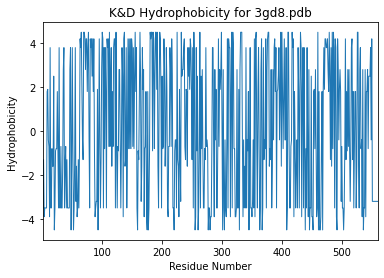

In [201]:
x_data = range(1, len(fasta_structures['5WQC']['structure'])+1)
plt.plot(x_data, values_hyd, linewidth=1.0)
plt.axis(xmin = 1, xmax = len(fasta_structures['5WQC']['structure']))
# plt.figure(figsize=(20, 15))
plt.xlabel("Residue Number")
plt.ylabel("Hydrophobicity")
plt.title("K&D Hydrophobicity for 3gd8.pdb")
plt.show()

In [202]:
fasta_structures['1KQF']['structure']

'MDVSRRQFFKICAGGMAGTTVAALGFAPKQALAQARNYKLLRAKEIRNTCTYCSVGCGLLMYSLGDGAKNAREAIYHIEGDPDHPVSRGALCPKGAGLLDYVNSENRLRYPEYRAPGSDKWQRISWEEAFSRIAKLMKADRDANFIEKNEQGVTVNRWLSTGMLCASGASNETGMLTQKFARSLGMLAVDNQARVUHGPTVASLAPTFGRGAMTNHWVDIKNANVVMVMGGNAAEAHPVGFRWAMEAKNNNDATLIVVDPRFTRTASVADIYAPIRSGTDITFLSGVLRYLIENNKINAEYVKHYTNASLLVRDDFAFEDGLFSGYDAEKRQYDKSSWNYQLDENGYAKRDETLTHPRCVWNLLKEHVSRYTPDVVENICGTPKADFLKVCEVLASTSAPDRTTTFLYALGWTQHTVGAQNIRTMAMIQLLLGNMGMAGGGVNALRGHSNIQGLTDLGLLSTSLPGYLTLPSEKQVDLQSYLEANTPKATLADQVNYWSNYPKFFVSLMKSFYGDAAQKENNWGYDWLPKWDQTYDVIKYFNMMDEGKVTGYFCQGFNPVASFPDKNKVVSCLSKLKYMVVIDPLVTETSTFWQNHGESNDVDPASIQTEVFRLPSTCFAEEDGSIANSGRWLQWHWKGQDAPGEARNDGEILAGIYHHLRELYQSEGGKGVEPLMKMSWNYKQPHEPQSDEVAKENNGYALEDLYDANGVLIAKKGQLLSSFAHLRDDGTTASSCWIYTGSWTEQGNQMANRDNSDPSGLGNTLGWAWAWPLNRRVLYNRASADINGKPWDPKRMLIQWNGSKWTGNDIPDFGNAAPGTPTGPFIMQPEGMGRLFAINKMAEGPFPEHYEPIETPLGTNPLHPNVVSNPVVRLYEQDALRMGKKEQFPYVGTTYRLTEHFHTWTKHALLNAIAQPEQFVEISETLAAAKGINNGDRVTVSSKRGFIRAVAVVTRRLKPLNVNGQQVETVGIPIHWGFEGVARKGYIANTLTPNVGDAN

In [152]:
fasta_structures['6WZG']['seq']['chain']

[[['F', 2.8, 0, 1],
  ['T', -0.7, 0, 1],
  ['S', -0.8, 0, 1],
  ['E', -3.5, 1, 1],
  ['L', 3.8, 0, 1],
  ['S', -0.8, 0, 1],
  ['R', -4.5, 1, 1],
  ['L', 3.8, 0, 1],
  ['R', -4.5, 1, 1],
  ['E', -3.5, 1, 1],
  ['G', -0.4, 0, 1],
  ['A', 1.8, 0, 1],
  ['R', -4.5, 1, 1],
  ['L', 3.8, 0, 1],
  ['Q', -3.5, 0, 1],
  ['R', -4.5, 1, 1],
  ['L', 3.8, 0, 1],
  ['L', 3.8, 0, 1],
  ['Q', -3.5, 0, 1],
  ['G', -0.4, 0, 1]]]

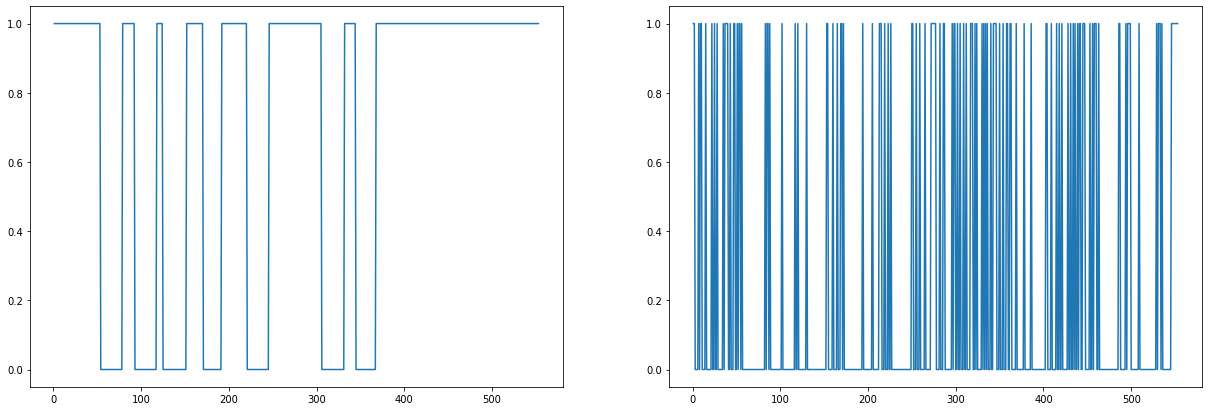

In [128]:
# transmembrane segments are 0
fig, axes = plt.subplots(1, 2, figsize=(21,7))
columns = list(zip(*fasta_structures['5WQC']['seq']['chain'][0]))
x_data = range(1, len(fasta_structures['5WQC']['structure'][5:-2])+1)
axes[0].plot(x_data, columns[3])
axes[1].plot(x_data, columns[2])

### Classifier

In [226]:
Y_pred , Y_true = [], []
math_cor_coef = []
clf = SGDClassifier(loss='perceptron')
outside_proteins = ['5VBL','7D77', '4LDE', '7EPE', '6FFI', '6WZG', '3WU2', '5O0T', '6MWA', '4U9N', "3RVY", '6X19', '6WJ6', '7EPF', '6WBV', '4PHZ', '7D3S', '7P2L', '7DUQ', '5VB8', '5YUA', '3JQO', '6K61', '6M0R', '5HK7']

for index, key in enumerate(fasta_structures):
  # get protein columns -> 0 is the residue name, 1 is the hydrophobicity value, 2 is the position in membrane
  columns = list(zip(*fasta_structures[key]['seq']['chain'][0]))
  # scaler = MinMaxScaler()
  # scaled_data = scaler.fit_transform((np.array(columns[1:3])).reshape(len(columns[1]),2))
  if key not in outside_proteins:
    if index <= 900:
      clf.partial_fit((np.array(columns[1:3])).reshape(len(columns[1]),2), columns[2], (np.array(columns[3])).reshape(len(columns[3])))
    else:
      pred = clf.predict((np.array(columns[1:3])).reshape(len(columns[1]),2))
      Y_pred.append(pred)
      Y_true.append(columns[3])
      math_cor_coef.append(matthews_corrcoef(columns[3], clf.predict((np.array(columns[1:3])).reshape(len(columns[1]),2))))

In [227]:
# +1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction
math_cor_coef

[0.13966554125788275,
 -0.09536151798826013,
 -0.10007923989603588,
 0.1736583998428773,
 -0.27579946467059974,
 0.0,
 0.10913642723182357,
 -0.08140527702071364,
 -0.1196862596783971,
 -0.21858347576206466,
 -0.020759644091965783,
 -0.15708406013029758,
 0.28437653875021324,
 0.1404207792357098,
 0.3236944786392251,
 -0.0049100807015018,
 -0.0871840050692037,
 -0.09109089805896652,
 0.055219725769855184,
 0.07142726459473762,
 0.16494698778769779,
 -0.10693102965333946,
 -0.09903806490917856,
 -0.025666354689770313,
 0.030806406828948273,
 -0.006219552647628449,
 -0.19710038684307937,
 0.08653973737988778,
 -0.053644905955656685,
 -0.17733830821968188,
 -0.029235267310234306,
 0.17122543145623156,
 -0.001580490663614343,
 -0.11233846629395508,
 0.21081851067789195,
 -0.05473887221970628,
 0.04249172830306691,
 0.06305678566283587,
 0.10234981980514062,
 -0.002533457261556584,
 -0.12864500851566815,
 0.19552948669513773,
 0.02037909199057202,
 0.09981935588701754,
 -0.02078073897865540

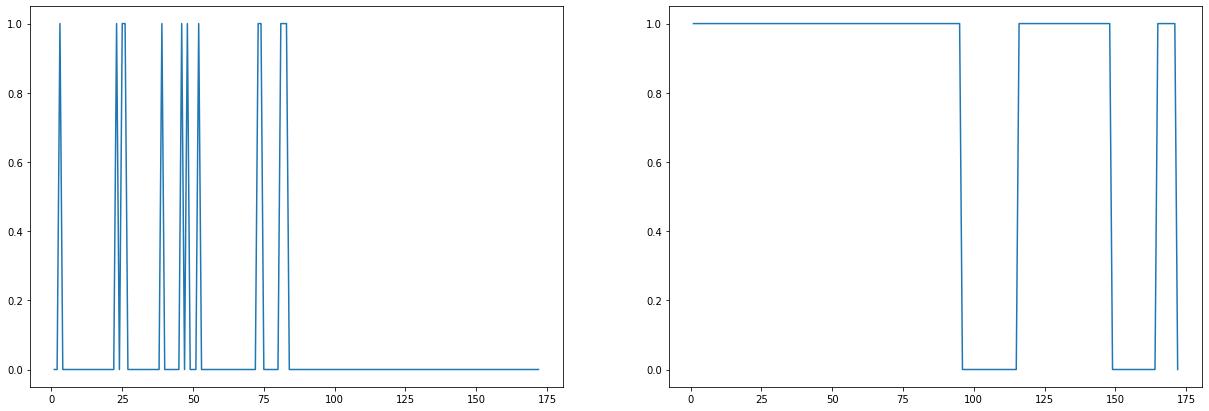

In [165]:
fig, axes = plt.subplots(1, 2, figsize=(21,7))
x_data = range(1, len(Y_pred[11])+1)
axes[0].plot(x_data, Y_pred[11])
axes[1].plot(x_data, Y_true[11])

### Tests

In [ ]:
polypeptide_builder = CaPPBuilder()

for polypeptide in polypeptide_builder.build_peptides(structure):
    seq = polypeptide.get_sequence()
analyzed_seq = ProteinAnalysis(str(seq))

# count the number of each type of amino acid
analyzed_seq.count_amino_acids()

{'A': 21,
 'C': 0,
 'D': 8,
 'E': 6,
 'F': 12,
 'G': 21,
 'H': 0,
 'I': 13,
 'K': 7,
 'L': 36,
 'M': 9,
 'N': 3,
 'P': 9,
 'Q': 2,
 'R': 6,
 'S': 10,
 'T': 16,
 'V': 21,
 'W': 8,
 'Y': 11}

<BarContainer object of 20 artists>

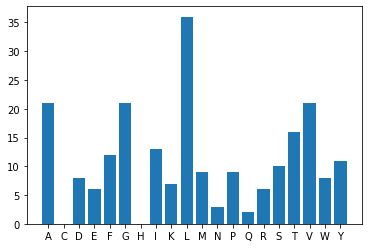

In [20]:
names, counts = zip(*analyzed_seq.count_amino_acids().items())
plt.bar(names, counts)

In [13]:
analyzed_seq.secondary_structure_fraction() # helix, turn, sheet

(0.4611872146118721, 0.1963470319634703, 0.3287671232876712)

In [18]:
analyzed_seq.protein_scale(window=7, param_dict=ProtParamData.kd)

[-0.4428571428571429,
 0.45714285714285713,
 1.2285714285714284,
 1.6714285714285715,
 1.7,
 1.3142857142857143,
 1.9857142857142855,
 1.7142857142857146,
 1.4000000000000001,
 1.4000000000000001,
 1.4000000000000001,
 1.4,
 1.6857142857142855,
 0.9571428571428571,
 1.0857142857142859,
 1.6857142857142857,
 1.7428571428571427,
 1.2428571428571427,
 1.2857142857142858,
 1.0142857142857142,
 1.1428571428571428,
 1.342857142857143,
 0.6857142857142858,
 -0.41428571428571453,
 -0.08571428571428578,
 -0.5285714285714286,
 -0.5428571428571429,
 -1.0428571428571427,
 -2.2,
 -1.6857142857142857,
 -1.3714285714285714,
 -0.8857142857142856,
 0.2571428571428571,
 -0.09999999999999999,
 0.35714285714285715,
 1.457142857142857,
 1.6571428571428573,
 1.614285714285714,
 1.6142857142857143,
 1.6142857142857143,
 1.9714285714285715,
 2.4714285714285715,
 1.8285714285714285,
 1.5,
 1.542857142857143,
 1.8285714285714287,
 1.0714285714285714,
 1.0857142857142856,
 1.2285714285714282,
 1.8714285714285712

In [49]:
seq = []
atoms = []

for line in open('1qjp.pdb'):
  list = line.split()
  id = list[0]

  if id == 'SEQRES':
    seq.append(list[4:])
  if id == 'ATOM':
    atoms.append(np.float128(list[6:9]))
  

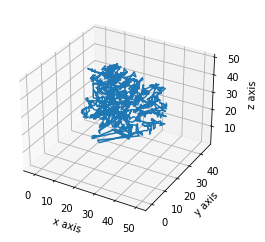

In [63]:
X,Y,Z=np.array(atoms).T
ax = plt.axes(projection='3d')

ax.plot3D(X,Y,Z)
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
plt.show()

In [64]:
polarity = ""
for row in seq:
  for amino in row:
    if amino in hydrophobic_amino_acid:
      polarity += " Non"
    else:
      polarity += " Polar"

In [35]:
polarity

' Non Non Polar Polar Polar Polar Non Polar Polar Polar Non Polar Non Polar Non Polar Polar Polar Polar Polar Polar Polar Non Non Polar Polar Polar Polar Non Polar Polar Polar Polar Polar Non Polar Non Polar Non Non Polar Polar Polar Polar Non Polar Non Polar Non Polar Non Polar Non Polar Polar Polar Non Non Polar Polar Non Non Polar Polar Polar Polar Non Polar Polar Polar Non Polar Polar Non Polar Polar Non Polar Non Polar Non Polar Non Polar Polar Non Non Polar Polar Polar Non Polar Non Polar Polar Polar Non Polar Polar Non Non Non Polar Non Polar Polar Polar Polar Polar Non Polar Polar Polar Polar Polar Polar Polar Polar Non Polar Non Non Non Non Polar Polar Non Polar Polar Non Non Polar Non Polar Non Non Polar Polar Non Polar Polar Polar Non Polar Polar Polar Non Polar Polar Non Polar Polar Non Polar Polar Polar Non Polar Polar Polar Non Non Polar Non Polar Non Polar Polar Polar Non Polar'